In [90]:
from collections import Counter
from math import floor
from typing import List, Union

from qiskit import QuantumCircuit, Aer, execute
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt

In [91]:
def reduce_frequency(data: Union[np.ndarray, List], M: int):
    if type(data) == list:
        freq = Counter(data)
        new_data = []
        for number, count in freq.items():
            new_count = floor(count / M)
            new_data.extend([number] * new_count)
        return new_data
    elif type(data) == np.ndarray:
        unique, counts = np.unique(data, return_counts=True)
        new_counts = np.floor_divide(counts, M)
        return np.repeat(unique, new_counts)
    else:
        raise ValueError('Unrecognized data type..')

# Function to compute fidelity between two states
def fidelity(state1, state2):
    return np.abs(np.dot(np.conj(state1), state2))**2

In [92]:
N = 1
simulator = Aer.get_backend('statevector_simulator')
N_samples = 1000
sampled_states = []
for sample in range(N_samples):
    qc = QuantumCircuit(N)
    """qc.h(0)
    qc.rz(qubit=0,phi=np.random.uniform(-np.pi, np.pi))"""
    psi = np.array(execute(qc, simulator).result().get_statevector())
    sampled_states.append(psi)


In [93]:
N_bins = 75

# Compute the fidelities for PQC
#fidelities_PQC = [fidelity(psi, phi) for psi in sampled_states for phi in sampled_states if not np.array_equal(psi, phi)]
fidelities_PQC = [fidelity(sampled_states[i], sampled_states[j]) for i in range(N_samples) for j in range(i+1,N_samples)]

# Generate Haar-random states for comparison
haar_states = [np.random.normal(size=(2**N,)) + 1j * np.random.normal(size=(2**N,)) for _ in range(len(sampled_states))]
haar_states = [psi / np.linalg.norm(psi) for psi in haar_states]
fidelities_Haar = [fidelity(psi, phi) for psi in haar_states for phi in haar_states if not np.array_equal(psi, phi)]

# Estimate the probability distributions
hist_PQC, bin_edges = np.histogram(fidelities_PQC, bins=N_bins)
hist_Haar, _ = np.histogram(fidelities_Haar, bins=bin_edges)
# Ensure non-zero values to avoid division by zero in KL divergence
hist_PQC = hist_PQC.astype(np.float64)
hist_Haar = hist_Haar.astype(np.float64)
hist_PQC += np.finfo(float).eps
hist_Haar += np.finfo(float).eps

In [94]:
# Calculate the KL divergence
D_KL = entropy(pk=hist_PQC, qk=hist_Haar)

print(f"KL Divergence: {D_KL}")


KL Divergence: 4.302111056301149


In [95]:
# Normalize frequencies
fidelities_PQC = reduce_frequency(data=fidelities_PQC, M=N_bins)
fidelities_Haar = reduce_frequency(data=fidelities_Haar, M=N_bins)

/Users/sebastianyde/miniforge3/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/Users/sebastianyde/miniforge3/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


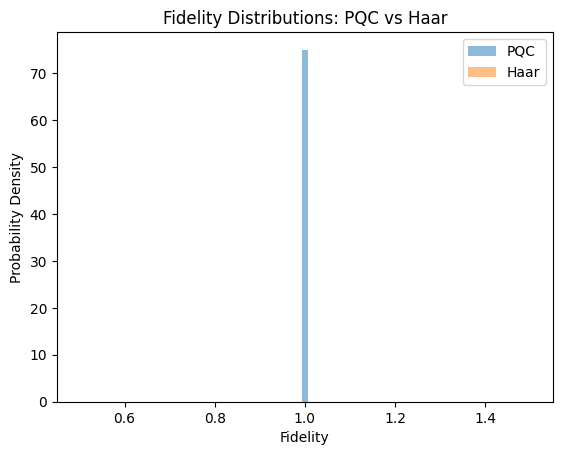

In [96]:
# Plot the histograms for both distributions
plt.hist(fidelities_PQC, bins=bin_edges, alpha=0.5, label='PQC', density=True)
plt.hist(fidelities_Haar, bins=bin_edges, alpha=0.5, label='Haar', density=True)

# Adding labels and title
plt.xlabel('Fidelity')
plt.ylabel('Probability Density')
plt.title('Fidelity Distributions: PQC vs Haar')
plt.legend()

# Show the plot
plt.show()

